<a href="https://colab.research.google.com/github/mr-pablinho/gaussian_random_fields/blob/main/GaussRandomField.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gaussian random field generator using Cholesky decomposition**


---



*Created on Thu Dec 23 13:53:50 2021\
Last update on Sun Mar 27 15:50:29 2022\
@author: Pablo Merchán-Rivera* 👻



---



Gaussian random fields are useful in many practical applications. For instance, hydrogeology and material sciences. I am sure there is a script out there but I was not able to find it. So, I created this one. 

As the name shows, a Gaussian random field is a random field involving Gaussian (a.k.a. Normal distributed) probability density functions of the variables. 

This Jupyter notebook can be used by anyone to understand what is going on, and also collaborate to optimize, correct and include new algorithms. Please, let me know if you find mistakes or you have any feedback.

## Import libraries

In [1]:
!pip install chaospy
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 247 kB 14.0 MB/s 
     |████████████████████████████████| 147 kB 43.6 MB/s 


## Generate random field

### Cholesky decomposition
The idea behind Cholesky decomposition is to factorize a Hermitian, positive-definite matrix into the product of its transpose and a lower triangular matrix. It is a powerful tool in algebra because it improves the efficiency to get numerical solutions.



In [20]:
def random_field(Nx, Ny, mu, sigma, corr_x=1, corr_y=1, cov_function='exponential', verbose=False):
    
    # print message
    print('Creating random field (%dx%d)... ' % (Nx, Ny))
    
    x_min, x_max, y_min, y_max = 0.0, 1*Nx, 0.0, 1*Ny
    mesh_size_x, mesh_size_y = Nx, Ny

    start_x, stop_x, step_x = x_min + x_max/(2*mesh_size_x), x_max, (x_max - x_min)/mesh_size_x
    start_y, stop_y, step_y = y_min + y_max/(2*mesh_size_y), y_max, (y_max - y_min)/mesh_size_y 
    
    x_coord = np.arange(start_x, stop_x, step_x)
    y_coord = np.arange(start_y, stop_y, step_y)
    
    if verbose == True:
        message_random_field(start_x, stop_x, step_x, x_coord, start_y, stop_y, step_y, y_coord)
    
    mesh_coord = [None] * (Nx*Ny)
    ii = 0
    for i in range(mesh_size_x):
        for j in range(mesh_size_y):
            mesh_coord[ii] = x_coord[i], y_coord[j]
            ii += 1

    C1 = np.zeros(shape=(Nx*Ny, Nx*Ny))

    for i in range(Nx*Ny):
        for j in range(Nx*Ny):
          if cov_function == 'exponential':
            C1[i, j] = c1(mesh_coord[i], mesh_coord[j], corr_x, corr_y)
            C1[i, i] += 1E-7 
          elif cov_function == 'squared exponential':
            C1[i, j] = c2(mesh_coord[i], mesh_coord[j], corr_x, corr_y)
            C1[i, i] += 1E-7
          else:
            print('Error: define the correct function!\n "exponential" or "squared exponential"')


    # perform Cholesky decomposition
    L1 = np.linalg.cholesky(C1)
      
    print('Creating gaussian random field (mu=%.3f, sigma=%.3f)' % (mu, sigma))
    
    dist = cp.Normal(0, sigma).sample((Nx*Ny))
    np.random.shuffle(dist)
    G1 = mu + np.matmul(L1, dist)
    foo = np.reshape(G1, (Nx,Ny)).T

    return foo

## Covariance functions

This function computes the spatial covariance of a random field. It can be exponential or squared exponential, depending on the output of interest. 

The squared exponential will create a smoother surface. 

In [21]:
# exponential 
def c1(x, y, corr_x, corr_y):
    d = (((x[0] - y[0])/corr_x) * ((x[0] - y[0])/corr_x)) + (((x[1] - y[1])/corr_y) * ((x[1] - y[1])/corr_y))
    return np.exp(-(np.sqrt(d)))

# squared exponential
def c2(x, y, corr_x, corr_y):
    d = (((x[0] - y[0])/corr_x) * ((x[0] - y[0])/corr_x)) + (((x[1] - y[1])/corr_y) * ((x[1] - y[1])/corr_y))
    return np.exp(-d * 0.5)


Just a message to observe the spatial discretization.

In [22]:
# verbose message
def message_random_field(start_x, stop_x, step_x, x_coord, start_y, stop_y, step_y, y_coord):
    print('Mesh for random field:')
    print('x-coord -->  start: %.3f, stop: %.3f, step: %.3f, length:%.3f' % (start_x, stop_x, step_x, len(x_coord)))
    print('y-coord -->  start: %.3f, stop: %.3f, step: %.3f, length:%.3f' % (start_y, stop_y, step_y, len(y_coord)))
    print('---'*10)
    print('x-coord array --> %s' % (x_coord))
    print('y-coord array --> %s' % (y_coord))

## Field parameters

Define the parameters for the generation of the field. 

Notice that the mean (mu) and the standard deviation (sigma) that describe the gaussian probaility are in logarithmic scale.

In [25]:
# Example:
Nx = 30
Ny = 30

# hydraulic conductivity field
np.random.seed(seed=1234) # random seed
mu, sigma = -3, .5  # mean and standard deviation
dist_type = 'Gaussian'  # distribution type
corr_x = 6  # correlation in x
corr_y = 6  # correlation in y
cov_function = 'exponential'  # covariance function type (exponential, squared exponential or both)

# compute field (exponential covariance function)
field_exponential = random_field(Nx, Ny,
                                 mu, sigma, 
                                 corr_x=corr_x, corr_y=corr_y, 
                                 cov_function='exponential', 
                                 verbose=False)

# compute field (exponential covariance function)
field_sqexponential = random_field(Nx, Ny, 
                                   mu, sigma, 
                                   corr_x=corr_x, corr_y=corr_y,
                                   cov_function='squared exponential', 
                                   verbose=False)



Creating random field (30x30)... 
Creating gaussian random field (mu=-3.000, sigma=0.500)
Creating random field (30x30)... 
Creating gaussian random field (mu=-3.000, sigma=0.500)


## Plot results

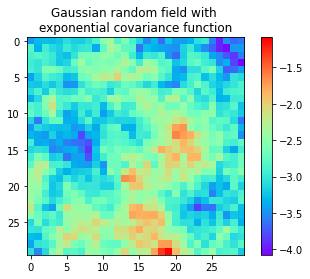

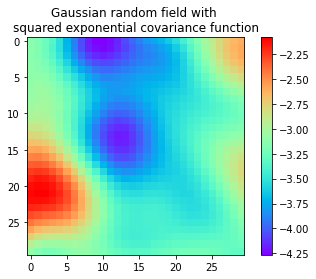

In [28]:
plt.figure('Exponential')
plt.imshow(field_exponential, cmap='rainbow')
plt.title('Gaussian random field with \nexponential covariance function')
plt.colorbar()

plt.figure('Squared exponential')
plt.imshow(field_sqexponential, cmap='rainbow')
plt.title('Gaussian random field with \nsquared exponential covariance function')
plt.colorbar()